In [4]:
from dxfwrite import DXFEngine as dxf
import numpy as np
import matplotlib.pyplot as plt
#import microfluidics_class as mf
from copy import deepcopy

from microfluidics_class import Design
from microfluidics_class import Feature

In [2]:
design.file = '/Users/guillaume/Desktop/test_class3.dxf'

NameError: name 'design' is not defined

In [5]:
design = Design()
design.add_layer('Layer1', {'name':'first_layer','color':1, 'inversion':0})
design.add_layer('Layer2', {'name':'sec_layer','color':2, 'inversion':0})
design.add_layer('Layer3', {'name':'third_layer','color':3, 'inversion':0})
design.add_layer('Layer4', {'name':'fourth_layer','color':4, 'inversion':0})

In [6]:
design2 = Design()
design2.add_layer('Layer1', {'name':'first_layer','color':1, 'inversion':0})
design2.add_layer('Layer2', {'name':'sec_layer','color':2, 'inversion':0})
design2.add_layer('Layer3', {'name':'third_layer','color':3, 'inversion':0})
design2.add_layer('Layer4', {'name':'fourth_layer','color':4, 'inversion':0})

In [7]:
tube_coord = [[0,0],[1000,0],[1000,1000]]
tube_rad = 20
tube_curv = [0,50,0]

In [8]:
myfeature1 = tube_broken = Feature.define_tube_broken(tube_coord,50, 20, 100)
#Feature.define_tube(tube_coord,tube_curv,tube_rad)
myfeature1.set_layer('Layer1')
myfeature1.set_mirror(0)

In [9]:
polygon = [300*np.array([np.sin(x),np.cos(x)]) for x in np.arange(0,2*np.pi,0.1)]
polyfeature = Feature.define_polygon(polygon).set_layer('Layer4')


In [10]:
myfeature2 = Feature.circular_punching(nb_points=20,outer_rad=100,position=[0,0]).set_layer('Layer2')

In [11]:
#copy a given feature and move it
myfeature2_copy = myfeature2.copy().move([1000,2000])

In [19]:
design.add_feature('myfirstfeature', myfeature1)
design.add_feature('mysecondfeature', myfeature2)
design2.add_feature('mysecondfeature', myfeature2_copy)
design2.add_feature('polygon', polyfeature)

In [20]:
design.features

{'myfirstfeature': <microfluidics_class.Feature at 0x1066cd5c0>,
 'myfirstfeature_mirror': <microfluidics_class.Feature at 0x10675e4e0>,
 'mysecondfeature': <microfluidics_class.Feature at 0x10664de10>}

In [21]:
design2.features

{'mysecondfeature': <microfluidics_class.Feature at 0x1066cd6d8>,
 'mysecondfeature_copy': <microfluidics_class.Feature at 0x1066cd6d8>,
 'polygon': <microfluidics_class.Feature at 0x1066cd828>}

In [22]:
design3 = sum(design+design2

In [23]:
design3.features

{'myfirstfeature': <microfluidics_class.Feature at 0x10675ed30>,
 'myfirstfeature_mirror': <microfluidics_class.Feature at 0x10675edd8>,
 'mysecondfeature': <microfluidics_class.Feature at 0x10675ed68>,
 'mysecondfeature0': <microfluidics_class.Feature at 0x1066cd6d8>,
 'mysecondfeature_copy': <microfluidics_class.Feature at 0x1066cd6d8>,
 'polygon': <microfluidics_class.Feature at 0x1066cd828>}

In [41]:
myfeature3 = Feature.channel_array(length=100,num=2,origin=[0,-1000],space=200,space_series=200,subsampling=1,widths=[1,2]).set_layer('Layer1')
numfeature = Feature.numbering(num=18.6,pos=[2000,1000],rotation=np.pi/4,scale=10).set_layer('Layer1')
numarray = Feature.number_array(num_series=2,origin=[-2000,-1000],num=3,space=100,space_series=200,rotation=0,scale=5,subsampling=1).set_layer('Layer1')
pattern = Feature.patterned_region(channel_separation=10,channel_width=1,global_shape=[[200,200],[400,200],[400,400],[200,400]])
pattern.set_layer('Layer1')
align1, align2 = Feature.align_mark_squares(pos=[300,600])
align1.set_layer('Layer1')
align2.set_layer('Layer2')
combined = Feature.combine_features(align1,align2).set_layer('Layer3')
inverted = Feature.reverse_feature(numarray,[[-2000,-1050],[-1000,-1050],[-1000,-950],[-2000,-950]])
inverted.set_layer('Layer3')

In [42]:
design.add_feature('ch_array', myfeature3)
design.add_feature('numfeature', numfeature)
design.add_feature('numarray', numarray)
design.add_feature('pattern', pattern)
design.add_feature('align1', align1)
design.add_feature('align2', align2)
design.add_feature('combined', combined)
design.add_feature('inverted', inverted)

In [43]:
#copy design at multiple positions
fulldesign = design.multiplicate([[0,1000],[0,-1000]])

#draw full design
fulldesign.draw_design()

#close the drawing
fulldesign.close()

In [98]:
from bokeh.plotting import figure, output_notebook, show
output_notebook()
from ipywidgets import SelectMultiple
from ipywidgets import interactive
from ipywidgets import interact
from ipywidgets import Checkbox
from bokeh.models import Range1d

Loading BokehJS ...

In [99]:
sel_mult = SelectMultiple(options = [x for x in design.layers])

In [120]:
def g(m):

    layers_to_plot = m
    if len(layers_to_plot)>0:
        features_to_plot = [x for x in design.features if design.features[x].layer in layers_to_plot]
        if len(features_to_plot)>0:
            #chk = [Checkbox(description=a) for a in features_to_plot]
            #interact(updatePlot, **{c.description: c.value for c in chk})
            sel_mult2 = SelectMultiple(options = features_to_plot)
            interactive_plot2 = interactive(updatePlot, n=sel_mult2)
            display(interactive_plot2)
            
def find_min(cur_min, new_min):
    if new_min<cur_min:
        cur_min = new_min
    return cur_min

def find_max(cur_max, new_max):
    if new_max>cur_max:
        cur_max = new_max
    return cur_max

def update_bounds(cur_bound, feature_coord):
    cur_bound[0] = find_min(cur_bound[0],np.min([np.min(x[:,0]) for x in feature_coord]))
    cur_bound[1] = find_max(cur_bound[1],np.max([np.max(x[:,0]) for x in feature_coord]))

    cur_bound[2] = find_min(cur_bound[2],np.min([np.min(x[:,1]) for x in feature_coord]))
    cur_bound[3] = find_max(cur_bound[3],np.max([np.max(x[:,1]) for x in feature_coord]))

    return cur_bound


def updatePlot(n):
    #clear_output()
    features_to_plot = n
    if len(features_to_plot)>0:
        p = figure(title="simple line example", x_axis_label='x', y_axis_label='y',output_backend="webgl")
        cur_bound = [100000,-100000,100000,-100000]
        
        for elem in features_to_plot:
            toplot = design.features[elem].coord
            cur_bound = update_bounds(cur_bound, toplot)
            for tp in toplot:
                p.line(tp[:,0], tp[:,1])
            if not design.features[elem].mirror == None:
                flipped = design.features[elem].flip_feature(0).coord
                cur_bound = update_bounds(cur_bound, flipped)
                for tp in flipped:
                    p.line(tp[:,0], tp[:,1])
                    
        maxrange = np.max([cur_bound[1]-cur_bound[0],cur_bound[3]-cur_bound[2]])
        p.x_range=Range1d(cur_bound[0],cur_bound[0]+maxrange)
        p.y_range=Range1d(cur_bound[2],cur_bound[2]+maxrange)
        
        #p.x_range=Range1d(np.min([cur_bound[0],cur_bound[2]]),np.max([cur_bound[1],cur_bound[3]]))
        #p.y_range=Range1d(np.min([cur_bound[0],cur_bound[2]]),np.max([cur_bound[1],cur_bound[3]]))
        
        plot_height = 800
        plot_width = 800
        
        #plot_width = int(800*((cur_bound[1]-cur_bound[0])/(cur_bound[3]-cur_bound[2])))
        #plot_height = 800
        #if plot_width>800:
        #    p.plot_height = int(plot_height/(plot_width/800))
        #    p.plot_width = 800
        #elif plot_height>800:
        #    p.plot_width = int(plot_height/(plot_height/800))
        #    p.plot_height = 800
        #else:
        #    p.plot_width = plot_width
        #    p.plot_height = plot_height
        
        #p.plot_height = 100
        #p.inner_height = 100
        #p.inner_width  = 100
        
        show(p)

In [121]:
interactive_plot = interactive(g, m=sel_mult)
#interactive_plot.layout.height = '200'
#interactive_plot.layout.width = '100'
display(interactive_plot)

A Jupyter Widget

In [109]:
p3.

In [2]:
p3 = figure(title="simple line example", x_axis_label='x', y_axis_label='y')
p3.line([1,2,3],[1,2,3])

GlyphRenderer(id='69140a28-d91a-412b-9a4f-8f88cdc34622', ...)

In [7]:
p3.width =100
p3.height =100

In [8]:
show(p3)

In [7]:
from scipy import interpolate

In [16]:
tube = np.array(tube_coord)

In [15]:
tube_coord = [[0,0],[100,100],[200,0],[1000,0],[1000,1000]]

In [23]:
tck, u = interpolate.splprep([tube[:,0],tube[:,1]], k=1,s=0)

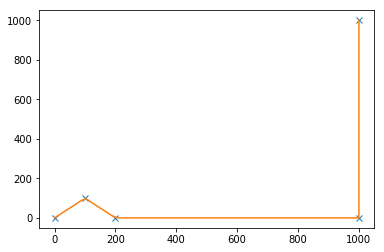

In [24]:
unew = np.arange(0, 1.01, 0.01)
out = interpolate.splev(unew, tck)
plt.figure()
plt.plot(tube[:,0], tube[:,1], 'x', out[0], out[1])
plt.show()

In [25]:
tube

array([[   0,    0],
       [ 100,  100],
       [ 200,    0],
       [1000,    0],
       [1000, 1000]])

In [48]:
t = np.concatenate([np.array([0]),np.cumsum(np.linalg.norm(np.diff(tube,axis=0), axis=1))])
tmax = t[-1]


In [29]:
np.diff(tube,axis=0)

array([[ 100,  100],
       [ 100, -100],
       [ 800,    0],
       [   0, 1000]])

In [30]:
(100**2+100**2)**0.5

141.4213562373095

In [39]:
t.shape
tube.shape

(5, 2)

In [52]:
splx, u = interpolate.splprep([np.diff(tube[:,0])/np.diff(t),tube[:-1,0]], k=1,s=0)
sply, u = interpolate.splprep([np.diff(tube[:,1])/np.diff(t),tube[:-1,1]], k=1,s=0)

In [51]:
splx

[array([ 0.        ,  0.        ,  0.09999989,  0.20000022,  1.        ,  1.        ]),
 [array([ 0.70710678,  0.70710678,  1.        ,  0.        ]),
  array([    0.,   100.,   200.,  1000.])],
 1]

In [46]:
np.concatenate([np.array([0]),t])

array([    0.        ,   141.42135624,   282.84271247,  1082.84271247,
        2082.84271247])

In [53]:
from shapely.geometry import LineString

In [66]:
test = LineString(tuple(tube))

In [69]:
np.array(test.coords)

array([[    0.,     0.],
       [  100.,   100.],
       [  200.,     0.],
       [ 1000.,     0.],
       [ 1000.,  1000.]])

In [104]:
unit_len = 10
totlen = np.sum(np.linalg.norm(np.diff(np.array(tube_coord),axis=0), axis=1))
interpol_points = np.array([np.array(LineString(tuple(tube_coord)).interpolate(x).coords).squeeze() for x in np.arange(0,totlen,unit_len/2)]).squeeze()


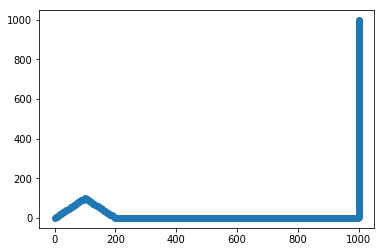

In [105]:
plt.plot(interpol_points[:,0],interpol_points[:,1],'o')
plt.show()

In [112]:
broken_lines = [interpol_points[x:x+3] for x in range(0,interpol_points.shape[0],4)]

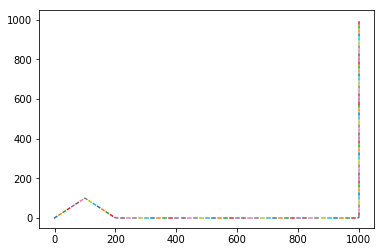

In [113]:
for x in broken_lines:
    plt.plot(x[:,0],x[:,1])
plt.show()

In [103]:
point_dist

416.5685424949238

In [5]:
tube_broken = Feature.define_tube_broken(tube_coord,50, 20, 10)

NameError: name 'define_tube' is not defined

In [12]:
nums = range(10)

In [14]:
nums[9]

9